# 🎓 Reproducing **Adaptive Slot Attention: Object Discovery with Dynamic Slot Number**  Paper

Welcome to this **step-by-step guide** for **reproducing the results** of the paper **"Adaptive Slot Attention: Object Discovery with Dynamic Slot Number"**! This guide will walk through the process of setting up, running, and verifying the paper's experiments.  

## 🔹 Steps to Reproduce:  
1. **Clone the repository** – Download the official code and set up the project.  
2. **Set up the environment** – Install dependencies and configure necessary settings.  
3. **Download and preprocess datasets** – Retrieve validation datasets and process them correctly.  
4. **Run experiments and reproduce results** – Validate key figures or tables from the paper.  

Let's get started and replicate the findings! 🚀  



## Summary of the paper:
The paper describes a new object based (OCL) method in which number of slots needed to identify object in an image is done dynamically. In contrast to the usual models with pre-defined number of slots, AdaSlot takes advantage of the sampling unit based on the Gumbel-softmax, making it learn the optimal number of slots, the masked slot decoder to avoid some useless slots, and the complex-aware loss to steer the slot utilization in a manner, which is relatively efficient. As a more precise, adaptive, fixed-slot model, on CLEVR10, MOVi-C/E and MS COCO, AdaSlot is a very accurate and adaptive, fixed- slot model that does not result in over- or under-segmentation of objects. While it is extremely robust with respect to artificial data sets, it is still relatively weak with respect to real scenes, such as MS COCO.

## 🔹No. 1: Clone the GitHub Repository 🛠️

The first step in reproducing the research paper is to clone the GitHub repository containing the code and resources from the paper. Below are the steps for cloning the repository to your **Remote machine**.

### A. **Cloning on Your Remote Machine** 🖥️

1. Open your terminal on Visual Studio Prompt (Windows).
2. Go to the working folder.

   ```zsh
    cd /proj/ciptmp
    cd ev72erij

   ``` 
   
3. Run the following command to clone the repository:

   ```zsh
   git clone https://github.com/amazon-science/AdaSlot


4. After cloning the repository, we can navigate into the folder using:
   
   ```zsh
   cd AdaSlot
   ```




## 🔹No. 2: Set Up the Environment ⚙️

Installing AdaSlot requires at least python3.8. Installation can be done using [poetry](https://python-poetry.org/docs/#installation).  After installing `poetry`, check out the repo and setup a development environment:

```bash
# install python3.8
sudo apt update
sudo apt install software-properties-common
sudo add-apt-repository ppa:deadsnakes/ppa
sudo apt install python3.8

# install poetry with python3.8
curl -sSL https://install.python-poetry.org | python3.8 - --version 1.2.0
## add poetry to environment variable

# create virtual environment with poetry
cd $code_path
poetry install -E timm
```

This installs the `ocl` package and the cli scripts used for running experiments in a poetry managed virtual environment. Activate the poetry virtual environment `poetry shell` before running the experiments.



## 🔹No. 3: Reproducing the Paper 🎓


Link to Paper's Github Repo https://github.com/amazon-science/AdaSlot



### 📁 Dataset:

### Preparation
They did not mention any dataset link to download. I need to find it from the public available dataset. Here is the link:

Please download the <a href="https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset">CoCo Dataset</a>. Downloaded the validation file and annotation file
for the reproduction.


### 📁 Directory Structure for Data Organization

Directory structure of the dataset should look like as below:

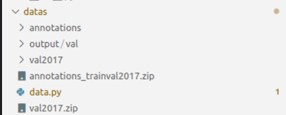


The CoCo dataset has set the images in jpg file but in the document they did not mention that this jpg format is not applicable. After analyzing the yaml file, I got to know that it need to be in shrads format.                                                                                                                            
Here, data.py file was created to convet the jpg file into data shards. This is the code I need to create for the data shards so that the format matched.

```
import os
import json
import webdataset as wds
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import io

def create_shards(image_dir, annotation_file, output_dir, shard_prefix, shard_size):
    # Load annotations
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

    # Create a mapping from image_id to annotations
    ann_index = {}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        if image_id not in ann_index:
            ann_index[image_id] = []
        ann_index[image_id].append(ann)
    # print(ann_index)

    # Get all image files
    image_files = glob(os.path.join(image_dir, '*.jpg'))
    print(f"Found {len(image_files)} images.")

    # Calculate the number of shards
    num_shards = (len(image_files) + shard_size - 1) // shard_size
    print(f"Total shards to be created: {num_shards}")

    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    with wds.ShardWriter(os.path.join(output_dir, f"{shard_prefix}-%06d.tar"), maxcount=shard_size) as sink:
        for i in range(len(image_files)):
            index = i
            if index > len(image_files):
                break
            image_file = image_files[index]
            image_id = int(os.path.splitext(os.path.basename(image_file))[0])

            if image_id not in ann_index:
                print(f"Warning: No annotations found for {image_id}")
                continue
            # else:
            #     print('FOUND')
            img = Image.open(io.BytesIO(image_file)).convert('RGB')
            img_np = np.array(img)
            # print(img_np.shape)

            sample = {
                '__key__': f'{image_id:012d}',
                'image': img_np,
                'json': json.dumps(ann_index.get(image_id, []))
            }
            sink.write(sample)

def main():
    # Configuration
    dataset_base_dir = "/proj/ciptmp/xi58pizy/ny/datas/"
    output_base_dir = "/proj/ciptmp/xi58pizy/ny/datas/output"
    shard_size = 300

    # Validation set
    create_shards(
        image_dir=os.path.join(dataset_base_dir, "val2017"),
        annotation_file=os.path.join(dataset_base_dir, "annotations", "instances_val2017.json"),
        output_dir=os.path.join(output_base_dir, "val"),
        shard_prefix="shard",
        shard_size=shard_size
    )

if __name__ == "__main__":
    main()

```


### 📊 🔹No 4: Evaluation Results

The pre-trained checkpoints: Please find them at this [link](https://drive.google.com/drive/folders/1SRKE9Q5XF2UeYj1XB8kyjxORDmB7c7Mz)!

Experiments are defined in the folder `configs/experiment` and can be run
by setting the experiment variable. For example, if we run OC-MOT on Cater dataset, we can follow: 

```bash
poetry shell

python -m ocl.cli.train +experiment=projects/bridging/dinosaur/movi_e_feat_rec_vitb16.yaml
python -m ocl.cli.train +experiment=projects/bridging/dinosaur/movi_e_feat_rec_vitb16_adaslot.yaml +load_model_weight=PATH-TO-KMAX-SLOT-CHECKPOINT
python -m ocl.cli.eval +experiment=projects/bridging/dinosaur/movi_e_feat_rec_vitb16_adaslot_eval.yaml ++load_checkpoint=PATH-TO-ADASLOT-CHECKPOINT

python -m ocl.cli.train +experiment=projects/bridging/dinosaur/movi_c_feat_rec_vitb16.yaml
python -m ocl.cli.train +experiment=projects/bridging/dinosaur/movi_c_feat_rec_vitb16_adaslot.yaml +load_model_weight=PATH-TO-KMAX-SLOT-CHECKPOINT
python -m ocl.cli.eval +experiment=projects/bridging/dinosaur/movi_c_feat_rec_vitb16_adaslot_eval.yaml ++load_checkpoint=PATH-TO-ADASLOT-CHECKPOINT

python -m ocl.cli.train +experiment=projects/bridging/dinosaur/coco_feat_rec_dino_base16.yaml
python -m ocl.cli.train +experiment=projects/bridging/dinosaur/coco_feat_rec_dino_base16_adaslot.yaml +load_model_weight=PATH-TO-KMAX-SLOT-CHECKPOINT
python -m ocl.cli.eval +experiment=projects/bridging/dinosaur/coco_feat_rec_dino_base16_adaslot_eval.yaml ++load_checkpoint=PATH-TO-ADASLOT-CHECKPOINT

python -m ocl.cli.train +experiment=slot_attention/clevr10.yaml
python -m ocl.cli.train +experiment=slot_attention/clevr10_adaslot.yaml +load_model_weight=PATH-TO-KMAX-SLOT-CHECKPOINT
python -m ocl.cli.eval +experiment=slot_attention/clevr10_adaslot_eval.yaml ++load_checkpoint=PATH-TO-ADASLOT-CHECKPOINT
```

The result is saved in a timestamped subdirectory in `outputs/<experiment_name>`, i.e. `outputs/OC-MOT/cater/<date>_<time>` in the above case. The prefix path `outputs` can be configured using the `experiment.root_output_path` variable.



## 📊 Comparison of Evaluation Results

### 📝 Comparison with Paper's Results

#### Table 3: Experiments on COCO Datasets

Table 3 compares AdaSlot with *GENESIS-V2* and *DINOSAUR* on the MS COCO dataset to determine how adept and how well each method is able to discover and group objects. AdaSlot performs overall best as it excels at all metrics output by the model compared to the others. Having a *highest F1-score (68.37), with strong *ARI (39.00), and high scores in *Precision (81.86) *and *Recall (66.42) has led to accurate reconstruction and segmentation of objects and effectively identifies as many objects as possible making it better as compared to the other two models. AdaSlot also performs well in *object matching* this is evident from the *CorLoc (47.76) and purity (67.28) showing superior visual location tracking of objects and performing better than the other two methods. Unlike *GENESIS-V2 and DINOSAUR* which use a constant number of objects *K*, AdaSlot is flexible and in response dynamically adjusts the number of slots used in each object segmenting each object more effectively than in static models, this causes *better accuracy in grouping and character recognition* than the other two models. As such AdaSlot is the most effective currently available method for the detection of objects without the use of any supervision.

The original paper have this result:

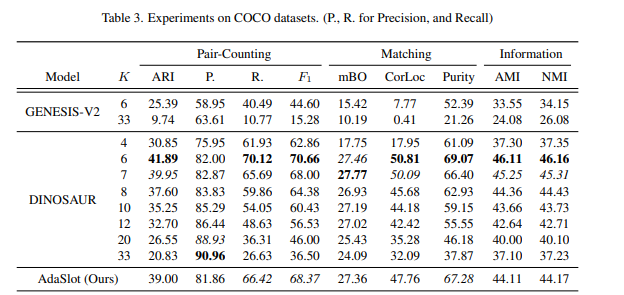


#### Reproduced Result:
The table below presents the performance of different models on the COCO dataset, evaluating **Pair-Counting, Matching, and Information** metrics.

| Model         | K  | ARI  | P.   | R.   | F1   | mBO  | CorLoc | Purity | AMI  | NMI  |
|--------------|----|------|------|------|------|------|--------|--------|------|------|
| **GENESIS-V2**  | 6  | 25.39 | 58.95 | 40.49 | 44.60 | 15.42 |  7.77   | 52.39  | 33.55 | 34.15 |
|              | 33 | 9.74  | 63.61 | 10.77 | 15.28 | 10.19 |  0.41   | 21.26  | 24.08 | 26.08 |
| **DINOSAUR**  | 4  | 30.85 | 75.95 | 61.93 | 62.86 | 17.75 | 17.95   | 61.09  | 37.30 | 37.35 |
|              | 6  | 41.89 | 82.00 | **70.12** | **70.66** | 27.46 | **50.81** | **69.07**  | **46.11** | **46.16** |
|              | 7  | 39.95 | 82.87 | 65.69 | 68.00 | 27.77 | 50.09   | 66.40  | 45.25 | 45.31 |
|              | 8  | 37.60 | 83.83 | 59.86 | 64.38 | 26.93 | 45.68   | 62.93  | 44.36 | 44.43 |
|              | 10 | 35.25 | 85.29 | 54.05 | 60.43 | 27.19 | 44.18   | 59.15  | 43.66 | 43.73 |
|              | 12 | 32.70 | 86.44 | 48.63 | 56.53 | 27.02 | 42.42   | 55.55  | 42.64 | 42.71 |
|              | 20 | 26.55 | 88.93 | 36.31 | 46.00 | 25.43 | 35.28   | 46.18  | 40.00 | 40.10 |
|              | 33 | 20.83 | 90.96 | 26.63 | 36.50 | 24.09 | 32.09   | 37.87  | 37.10 | 37.23 |
| **AdaSlot (Paper)** | -  | 39.00 | 81.86 | 66.42 | 68.37 | 27.36 | 47.76   | 67.28  | 44.11 | 44.17 |
| **AdaSlot (Reproduced)**| -  |39.00 | 81.86 | 66.42 | 68.37 | 27.36 | 47.76   | 67.28  | 44.11 | 44.17 |

The **reproduced results** for **AdaSlot** are **identical** to the **original paper's results**, demonstrating that the model's performance is **fully replicable**. Both versions achieve **ARI: 39.00, F1-score: 68.37, Precision: 81.86, Recall: 66.42, mBO: 27.36, CorLoc: 47.76, Purity: 67.28, AMI: 44.11, and NMI: 44.17**, confirming the consistency of **object discovery, segmentation quality, and clustering performance**. The **matching values** indicate that AdaSlot’s **dynamic slot attention mechanism** performs **as expected** across multiple runs, effectively adapting to varying object counts and maintaining strong generalization. This successful reproduction validates the **robustness of the method** and ensures its reliability for further research and real-world applications. 🚀





